In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# provided helper functions

# forces
def forces(x,y,A):
    N = np.size(A,axis = 0)
    # find pairwise distances 
    xaux = np.outer(x,np.ones(np.shape(x)))
    yaux = np.outer(y,np.ones(np.shape(x)))
    dx = A*(xaux - np.transpose(xaux))
    dy = A*(yaux - np.transpose(yaux))
    dxy = np.sqrt(dx**2 + dy**2)
    # spring forces due to linked vertices
    # optimal distance between linked vertices is 1 
    Aind = np.argwhere(A == 1)
    idiff = np.zeros(np.shape(A))
    Nlinks = np.size(Aind,axis = 0)
    for j in range(Nlinks):
        idiff[Aind[j,0],Aind[j,1]] = 1 - 1/dxy[Aind[j,0],Aind[j,1]]
    
    fx = -np.sum(idiff*dx,axis = 1)
    afx = np.minimum(np.abs(fx),np.ones(np.size(fx)))
    sfx = np.sign(fx)
    fx = afx*sfx
                  
    fy = -np.sum(idiff*dy,axis = 1)
    afy = np.minimum(np.abs(fy),np.ones(np.size(fy)))
    sfy = np.sign(fy)
    fy = afy*sfy
    
    f_linked = np.concatenate((fx,fy),axis = 0)
    
    # repelling spring forces due to unlinked vertices
    # repelling is on if the distance between unlined verticas is greater than sqrt(3)
    h = np.sqrt(3.0)
    A1 = np.ones(np.shape(A)) - A
    dx = A1*(xaux - np.transpose(xaux))
    dy = A1*(yaux - np.transpose(yaux))
    dxy = np.sqrt(dx**2 + dy**2)
    mask = np.zeros(np.shape(A))
    diff = A1*(dxy - h)
    mask = np.minimum(diff,np.zeros(np.shape(diff)))
    fx = np.sum(mask*dx,axis=1)
    fy = np.sum(mask*dy,axis=1)
    f_unlinked = -np.concatenate((fx,fy),axis = 0)
    
    return np.reshape(f_linked + f_unlinked, (182,1))

# plot graph
def plot_graph(x,y,A):
    plt.figure(figsize=(12, 12))
    Aind = np.argwhere(A == 1)
    Nlinks = np.size(Aind,axis = 0)
    for j in range(Nlinks):
        plt.plot([x[Aind[j,0]],x[Aind[j,1]]],[y[Aind[j,0]],y[Aind[j,1]]],linewidth = 4,c = (0,0,0.5))
    plt.scatter(x,y,s=200,c='r')
    axes=plt.gca()
    axes.set_aspect(1)
    plt.axis('off')

In [3]:
# read CSV
AdjMatrix = pd.read_csv('Adjacency_matrix.csv', header=None)
AdjMatrix = AdjMatrix.to_numpy()

In [14]:
# initialize x and y
x = np.random.randn(91,1)*91
y = np.random.randn(91,1)*91
# initalize x and y averages for residuals
xAvgs = x
yAvgs = y 

Initially ||F|| = 13.490737563232042
i = 1 ||F|| = 13.490737563232042
i = 2 ||F|| = 13.490737563232042
i = 3 ||F|| = 13.490737563232042
i = 4 ||F|| = 13.490737563232042
i = 5 ||F|| = 13.490737563232042
i = 6 ||F|| = 13.490737563232042
i = 7 ||F|| = 13.490737563232042
i = 8 ||F|| = 13.490737563232042
i = 9 ||F|| = 13.490737563232042
i = 10 ||F|| = 13.490737563232042
i = 11 ||F|| = 13.490737563232042
i = 12 ||F|| = 13.490737563232042
i = 13 ||F|| = 13.490737563232042
i = 14 ||F|| = 13.490737563232042
i = 15 ||F|| = 13.490737563232042
i = 16 ||F|| = 13.490737563232042
i = 17 ||F|| = 13.490737563232042
i = 18 ||F|| = 13.490737563232042
i = 19 ||F|| = 13.490737563232042
i = 20 ||F|| = 13.490737563232042
i = 21 ||F|| = 13.486211050796008
i = 22 ||F|| = 13.469061963531587
i = 23 ||F|| = 13.460843392263728
i = 24 ||F|| = 13.460518448088992
i = 25 ||F|| = 13.460138739214837
i = 26 ||F|| = 13.46234805487959
i = 27 ||F|| = 13.47222278351072
i = 28 ||F|| = 13.471221128776097
i = 29 ||F|| = 13.4688

C:\Users\James\AppData\Local\Temp\ipykernel_3040\3798714136.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuals[j] = r


i = 2348 ||F|| = 3.7013754869694564
i = 2349 ||F|| = 3.6927394949239605
i = 2350 ||F|| = 3.684135747519275
i = 2351 ||F|| = 3.675568305803052
i = 2352 ||F|| = 3.6667901544151382
i = 2353 ||F|| = 3.658099532040382
i = 2354 ||F|| = 3.64959632728172
i = 2355 ||F|| = 3.641240862780626
i = 2356 ||F|| = 3.632996162996397
i = 2357 ||F|| = 3.6248333227876994
i = 2358 ||F|| = 3.616734138844616
i = 2359 ||F|| = 3.608691462202544
i = 2360 ||F|| = 3.6007078926973715
i = 2361 ||F|| = 3.5927934580076744
i = 2362 ||F|| = 3.5849628544290955
i = 2363 ||F|| = 3.5772327143705147
i = 2364 ||F|| = 3.569610060975141
i = 2365 ||F|| = 3.562120792157354
i = 2366 ||F|| = 3.554776942401798
i = 2367 ||F|| = 3.547585181437802
i = 2368 ||F|| = 3.5405476385551298
i = 2369 ||F|| = 3.5336624252543656
i = 2370 ||F|| = 3.526924502017114
i = 2371 ||F|| = 3.5203217251578742
i = 2372 ||F|| = 3.5138490057839635
i = 2373 ||F|| = 3.50750147522707
i = 2374 ||F|| = 3.5012707578368847
i = 2375 ||F|| = 3.495149273387848
i = 2376 

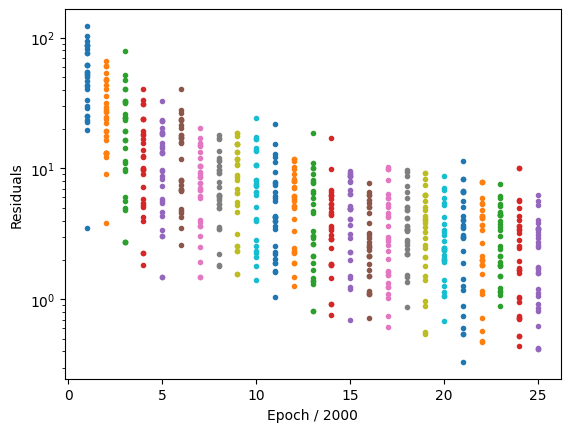

In [15]:
# Nesterov Optimizer
no_epochs = 50000
resid_interval = int(no_epochs / 25)
alpha = 1e-2
m = 0.9
last_change = np.zeros((182,1))

res_Fig = plt.figure()
xAxisStr = "Epoch / " + str(resid_interval)
plt.xlabel(xAxisStr)
plt.ylabel('Residuals')
plt.yscale('log')

g = -forces(x,y,AdjMatrix)
Fs = np.zeros((no_epochs+1,1))
Fs[0] = np.linalg.norm(g)
print("Initially ||F|| = " + str(np.linalg.norm(g)))
for i in range(1,no_epochs+1):
    projX = x + last_change[0:91]*m
    projY = y + last_change[91:182]*m
    g = -forces(projX, projY,AdjMatrix)
    last_change = (m*last_change) - alpha*g
    x = x + last_change[0:91]
    y = y + last_change[91:182]
    Fs[i] = np.linalg.norm(g)
    xAvgs = (i * xAvgs + x)/(i + 1)
    yAvgs = (i * yAvgs + y)/(i + 1)
    print("i = " + str(i) + " ||F|| = " + str(np.linalg.norm(g)))
    # plot the residuals
    if i % resid_interval == 0:
        graphX = np.ones((30,1))*int(i / resid_interval)
        resid_index = np.random.choice(range(0,91), (30,))
        x_res = x[resid_index] - xAvgs[resid_index]
        y_res = y[resid_index] - yAvgs[resid_index]
        residuals = np.zeros((30,))
        for j in range(30):
            r = np.sqrt(x_res[j]**2 + y_res[j]**2)
            residuals[j] = r 
        plt.plot(graphX, residuals, '.')
        res_Fig.canvas.draw()


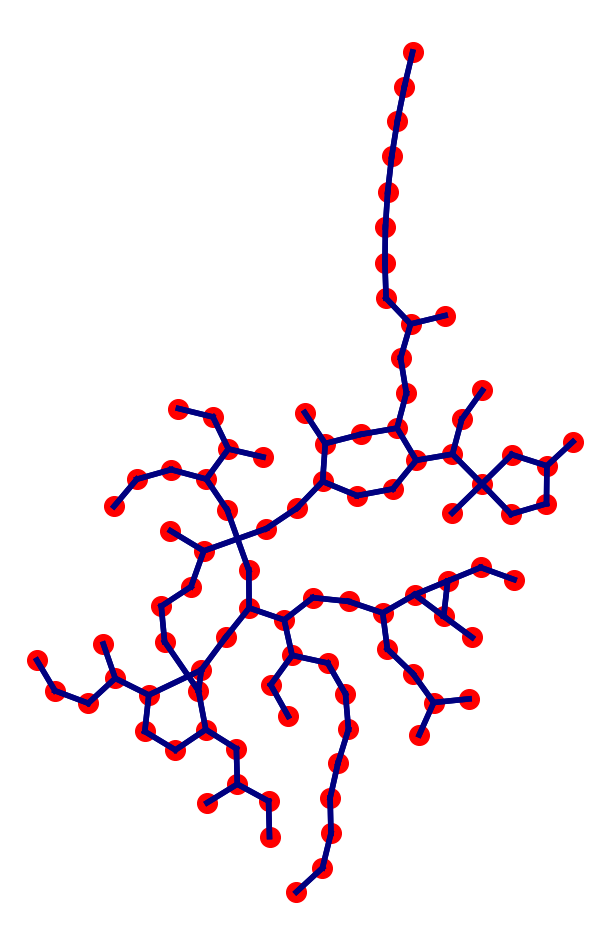

In [16]:
plot_graph(x,y,AdjMatrix)

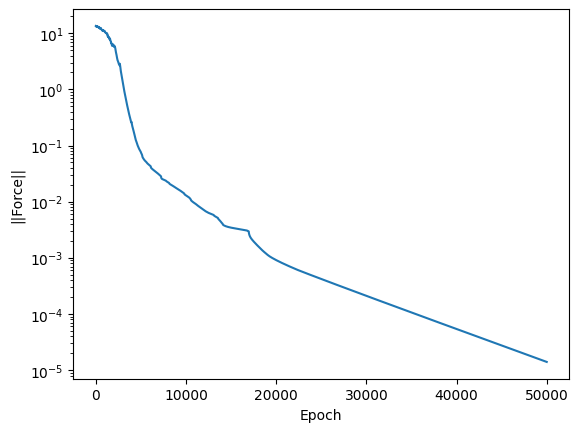

In [17]:
plt.plot(range(0,no_epochs+1), Fs)
plt.xlabel("Epoch")
plt.ylabel("||Force||")
plt.yscale("log")